# 随机森林决策统计
在训练随机森林分类器后，我们可以研究其内部机制。APOC允许我们获取基于给定特征的森林中的决策数量。

另请参阅
* [特征重要性](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
* [理解特征重要性并在Python中实现它（Towards Data Science）](https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285)

In [1]:
from skimage.io import imread, imsave
import pyclesperanto_prototype as cle
import pandas as pd
import numpy as np
import apoc
import matplotlib.pyplot as plt
import pandas as pd

cle.select_device('RTX')

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

为了演示目的，我们使用了David Legland在[CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)许可下分享的一张图像，该图像可在[mathematical_morphology_with_MorphoLibJ](https://github.com/dlegland/mathematical_morphology_with_MorphoLibJ/blob/master/sampleImages/maize_clsm.tif)仓库中找到。

我们还添加了一个在之前章节中生成的标签图像。

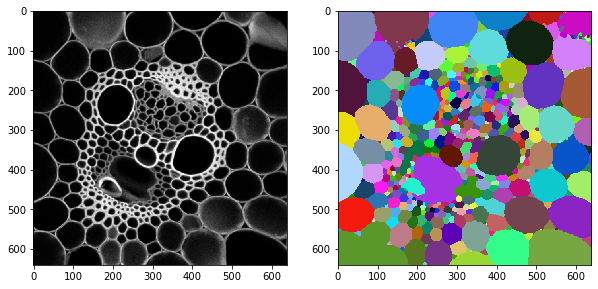

In [2]:
image = cle.push(imread('../../data/maize_clsm.tif'))
labels = cle.push(imread('../../data/maize_clsm_labels.tif'))

fix, axs = plt.subplots(1,2, figsize=(10,10))
cle.imshow(image, plot=axs[0])
cle.imshow(labels, plot=axs[1], labels=True)

我们之前创建了一个对象分类器，现在将其应用于强度和标签图像对。

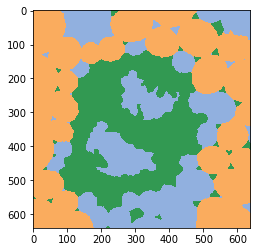

In [3]:
classifier = apoc.ObjectClassifier("../../data/maize_cslm_object_classifier.cl")
classification_map = classifier.predict(labels=labels, image=image)

cle.imshow(classification_map, labels=True, min_display_intensity=0)

## 分类器统计
加载的分类器可以给我们提供关于其内部结构的统计信息。随机森林分类器由许多决策树组成，每个决策树由多个层次上的二元决策组成。例如，一个有10棵树的森林在第一层做出10个决策，因为每棵树至少做出这一个决策。在第二层，每棵树最多可以做出2个决策，这导致这一层最多有20个决策。我们现在可以可视化每一层有多少决策考虑了特定的特征。这些统计数据以两个字典的形式给出，可以使用[pandas](https://pandas.pydata.org/)进行可视化

In [4]:
shares, counts = classifier.statistics()

首先，我们显示每一层的决策数量。同样，从低层到高层，决策的总数增加，在这个表格中从左到右增加。

In [5]:
pd.DataFrame(counts).T

0   1
area                                        4  33
mean_intensity                             32  44
standard_deviation_intensity               37  44
touching_neighbor_count                     8  28
average_distance_of_n_nearest_neighbors=6  19  34

上面的表格告诉我们，在第一层，26棵树考虑了`mean_intensity`，这是这一层中最高的数字。在第二层，有30个决策考虑了`standard_deviation_intensity`。在这一层，n个最近邻的平均距离被考虑了21-29次，这个数字很接近。你可以说强度和邻居之间的质心距离是区分对象的关键参数。

接下来，我们看一下标准化的`shares`，这是每个深度层的决策总数除以计数得到的。我们用颜色来可视化这个，以突出显示具有高值和低值的特征。

In [6]:
def colorize(styler):
    styler.background_gradient(axis=None, cmap="rainbow")
    return styler

df = pd.DataFrame(shares).T
df.style.pipe(colorize)

在我们上面描述的见解的基础上，我们还可以看到，随着层级的升高，各层决策的分布变得更加均匀。因此，可以考虑训练一个可能只有两个深度层的分类器。

## 特征重要性
研究提取特征相关性的一个更常见的概念是[特征重要性](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)，它是从上面显示的分类器统计数据计算得出的，可能更容易解释，因为它是描述每个特征的单一数值。

In [7]:
feature_importance = classifier.feature_importances()
feature_importance = {k:[v] for k, v in feature_importance.items()}
feature_importance

{'area': [0.1023460967511782],
 'mean_intensity': [0.27884719464885743],
 'standard_deviation_intensity': [0.34910187501327306],
 'touching_neighbor_count': [0.09231893555382481],
 'average_distance_of_n_nearest_neighbors=6': [0.1773858980328665]}

In [8]:
def colorize(styler):
    styler.background_gradient(axis=None, cmap="rainbow")
    return styler

df = pd.DataFrame(feature_importance).T
df.style.pipe(colorize)